In [147]:
import os
import pandas
import nibabel as ni
import numpy as np
import scipy.stats as stats
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from statsmodels.sandbox.stats.multicomp import multipletests
from nilearn import image, input_data

In [15]:
sdir = '/Users/jakevogel/Downloads/normalized_microarray_donor9861/'
coords = pandas.read_csv(os.path.join(sdir,'SampleAnnot.csv'))
probe_info = pandas.read_csv(os.path.join(sdir,'Probes.csv'))
qc = pandas.read_csv(os.path.join(sdir,'PACall.csv'),header=None)

KeyboardInterrupt: 

In [16]:
data = pandas.read_csv(os.path.join(sdir,'MicroarrayExpression.csv'),header=None)

In [37]:
H1 = ni.load('/Users/jakevogel/Science/tau/tau_masks/shipping/tau_masks/vogel_figshare/winner_takes_all/TauRUS_WinnerTakesAll_Hippocampus_Off-Target.nii.gz'
            ).get_data()
H3 = ni.load('/Users/jakevogel/Science/tau/tau_masks/shipping/tau_masks/vogel_figshare/winner_takes_all/TauRUS_WinnerTakesAll_Hippocampus_Early_Tau.nii.gz'
            ).get_data()

In [35]:
ac = [(round(coords.mni_x[i]),
      round(coords.mni_y[i]),
      round(coords.mni_z[i])) for i in range(len(coords))]

In [42]:
ac[0][0],ac[0][1],ac[0][2]

(6.0, -28.0, 50.0)

In [40]:
H2[ac[0][0],ac[0][1],ac[0][2]]

//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


0.0

In [41]:
[all_coords[x] for x in range(len(all_coords)) if H2[all_coords[x]] == 1]

//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


[]

MNI SPACE

In [174]:
def convert_coords(coord, to_what = 'mni', vs = 1):
    origin = [90, 126, 72]
    vs = vs
    (np.array(origin) / vs).astype(int).tolist()
    x,y,z = coord[0],coord[1],coord[2]
    
    if to_what == 'mni':
        x = (origin[0]-x)*vs
        y = (y-origin[1])*vs
        z = (z-origin[2])*vs
        
    elif to_what == 'xyz':
        x=origin[0]- x/vs
        y=y/vs + origin[1]
        z=z/vs + origin[2]
        
    else:
        raise IOError('please set to_what to either mni or xyz')
    
    return x,y,z

In [57]:
coords.columns

Index(['structure_id', 'slab_num', 'well_id', 'slab_type', 'structure_acronym',
       'structure_name', 'polygon_id', 'mri_voxel_x', 'mri_voxel_y',
       'mri_voxel_z', 'mni_x', 'mni_y', 'mni_z'],
      dtype='object')

In [60]:
a,b,c = coords.loc[coords.index[0]][['mni_x','mni_y','mni_z']].values
a

5.9000000000000004

In [80]:
hits_idx_3 = {}
for i in coords.index:
    mni_cs = coords.loc[i][['mni_x','mni_y','mni_z']]
    x,y,z = convert_coords(mni_cs, to_what = 'xyz')
    if H3[x,y,z] == 1:
        hits_idx_3.update({i: (x,y,z)})

//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [81]:
hits_idx_1 = {}
for i in coords.index:
    mni_cs = coords.loc[i][['mni_x','mni_y','mni_z']]
    x,y,z = convert_coords(mni_cs, to_what = 'xyz')
    if H1[x,y,z] == 1:
        hits_idx_1.update({i: (x,y,z)})

//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [82]:
hits_idx_3.keys()

dict_keys([306, 532, 533, 582, 580, 554, 796, 44, 530, 573])

In [86]:
data.iloc[:,list(hits_idx_3.keys())].mean(axis=1)

0         2.643289
1         1.560705
2         1.676049
3         5.373549
4         7.523561
5         8.377252
6        10.950905
7         5.883881
8         7.992006
9         3.615337
10       12.174057
11        9.849032
12       11.117673
13        3.000522
14        3.789344
15        1.775950
16        9.644368
17        5.881371
18        4.501402
19       10.325309
20       10.384866
21        5.459606
22        5.110865
23        6.946877
24        9.497831
25        8.875330
26        9.408522
27        6.886190
28        6.759526
29        9.631543
           ...    
58662     1.820298
58663     2.599219
58664     1.656004
58665     1.994733
58666     7.298187
58667     1.756525
58668    10.188729
58669     1.987665
58670     2.193815
58671    10.340270
58672     2.661737
58673     1.843563
58674     3.194600
58675     9.699841
58676     1.587918
58677     1.674414
58678     7.990807
58679     1.712902
58680    10.215604
58681     1.607155
58682     6.262849
58683     4.

In [35]:
jnk

,tst
1,5.0


In [45]:
def ABA_average_expression_from_atlas(ABA_dir, atlas, binary=False, save=False, average = True, save_coords = False):
    
    ABA_subs = sorted(glob(os.path.join(ABA_dir,'normalized_microarray_donor*')))
    final_out = {}
    print('preparing image...')
    atl = ni.load(atlas).get_data()
    if average:
        outnm = 'avg'
    else:
        outnm = 'all'
    if save_coords:
        cdf = pandas.DataFrame(columns = ['sub','label','x','y','z'])
    
    for sdir in ABA_subs:
        sid = os.path.split(sdir)[-1].split('donor')[-1]
        print('working on subject',sid)
        print('loading data...')
        coords = pandas.read_csv(os.path.join(sdir,'SampleAnnot.csv'))
        if binary:
            data = pandas.read_csv(os.path.join(sdir,'PACall.csv'),header=None)
        else:
            data = pandas.read_csv(os.path.join(sdir,'MicroarrayExpression.csv'),header=None)
        output = pandas.DataFrame(index = data.index)
        for lab in np.unique(atl)[1:]:
            print('searching for probes in label',lab)
            hits_idx = {}
            for i in coords.index:
                mni_cs = coords.loc[i][['mni_x','mni_y','mni_z']]
                x,y,z = convert_coords(mni_cs, to_what = 'xyz')
                x,y,z = int(round(x)), int(round(y)), int(round(z))
                if atl[x,y,z] == lab:
                    hits_idx.update({i: (x,y,z)})
                    if save_coords:
                        cdf.loc[:,'sub'] = sid
                        cdf.loc[:,'label'] = i
                        cdf.loc[:,'x'] = x
                        cdf.loc[:,'y'] = y
                        cdf.loc[:,'z'] = z
                    if not average:
                        output.loc[:,'lab_%s_samp_%s'%(lab,i)] = data.iloc[:,i]
            print('found %s hits'%(len(hits_idx.keys())))
            if average:
                output.loc[:,'lab_%s'%lab] = data.iloc[:,list(hits_idx.keys())].mean(axis=1)
            
                    
        print('finishing up subject',sid)
        final_out.update({sid: output})
        if save:
            output.to_csv(os.path.join(ABA_dir,'%s_%s_expression_data.csv'%(sid,outnm)))
            
    if save_coords:
        cdf.to_csv(os.path.join(ABA_dir,'hit_coordinates.csv'))
        
    return final_out

In [92]:
ABA_dir = '/Users/jakevogel/Downloads/'
atlas = '/Users/jakevogel/Science/tau/tau_masks/1mm_lund/hippocampus_labels_LUND_scif55.nii.gz'
t1 = ABA_average_expression_from_atlas(ABA_dir, atlas)

working on subject 1
loading data...
preparing image...
searching for probes in label 1.0


//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


found 39 hits
searching for probes in label 3.0
found 10 hits
finishing up subject 1


In [94]:
t1['1']

,lab_1.0,lab_3.0
0,2.968873,2.643289
1,1.725170,1.560705
2,1.750512,1.676049
3,4.958166,5.373549
4,7.331524,7.523561
5,8.040014,8.377252
6,10.630404,10.950905
7,4.690699,5.883881
8,8.999065,7.992006
9,2.885057,3.615337


In [38]:
ABA_dir = '/data1/users/jvogel/Allen_Human_Brain_Atlas/'
atlas = '/home/users/jvogel/Science/templates/atlases/Lund/hippocampus_labels_LUND_scif55.nii.gz'
avg_xp = ABA_average_expression_from_atlas(ABA_dir, atlas, save=True)

preparing image...
working on subject 10021
loading data...
searching for probes in label 1.0
found 27 hits
searching for probes in label 3.0
found 11 hits
finishing up subject 10021
working on subject 12876
loading data...
searching for probes in label 1.0
found 27 hits
searching for probes in label 3.0
found 11 hits
finishing up subject 12876
working on subject 14380
loading data...
searching for probes in label 1.0
found 12 hits
searching for probes in label 3.0
found 6 hits
finishing up subject 14380
working on subject 15496
loading data...
searching for probes in label 1.0
found 3 hits
searching for probes in label 3.0
found 4 hits
finishing up subject 15496
working on subject 15697
loading data...
searching for probes in label 1.0
found 9 hits
searching for probes in label 3.0
found 4 hits
finishing up subject 15697
working on subject 9861
loading data...
searching for probes in label 1.0
found 43 hits
searching for probes in label 3.0
found 12 hits
finishing up subject 9861


In [46]:
ABA_dir = '/data1/users/jvogel/Allen_Human_Brain_Atlas/'
atlas = '/home/users/jvogel/Science/templates/atlases/Lund/hippocampus_labels_LUND_scif55.nii.gz'
total_xp = ABA_average_expression_from_atlas(ABA_dir, atlas, save=True, average=False, save_coords=True)

preparing image...
working on subject 10021
loading data...
searching for probes in label 1.0
found 27 hits
searching for probes in label 3.0
found 11 hits
finishing up subject 10021
working on subject 12876
loading data...
searching for probes in label 1.0
found 27 hits
searching for probes in label 3.0
found 11 hits
finishing up subject 12876
working on subject 14380
loading data...
searching for probes in label 1.0
found 12 hits
searching for probes in label 3.0
found 6 hits
finishing up subject 14380
working on subject 15496
loading data...
searching for probes in label 1.0
found 3 hits
searching for probes in label 3.0
found 4 hits
finishing up subject 15496
working on subject 15697
loading data...
searching for probes in label 1.0
found 9 hits
searching for probes in label 3.0
found 4 hits
finishing up subject 15697
working on subject 9861
loading data...
searching for probes in label 1.0
found 43 hits
searching for probes in label 3.0
found 12 hits
finishing up subject 9861


In [47]:
total_xp['10021']

,lab_1.0_samp_524,lab_1.0_samp_525,lab_1.0_samp_527,lab_1.0_samp_529,lab_1.0_samp_531,lab_1.0_samp_532,lab_1.0_samp_533,lab_1.0_samp_534,lab_1.0_samp_544,lab_1.0_samp_545,...,lab_3.0_samp_552,lab_3.0_samp_559,lab_3.0_samp_561,lab_3.0_samp_563,lab_3.0_samp_565,lab_3.0_samp_646,lab_3.0_samp_746,lab_3.0_samp_777,lab_3.0_samp_778,lab_3.0_samp_875
0,3.943230,4.020999,4.175876,1.745893,4.073564,3.265115,4.056357,4.522288,3.535812,3.490434,...,3.362106,3.553705,3.372515,3.926045,3.766396,2.948741,4.059337,4.264056,3.569515,3.528191
1,1.279049,1.279049,1.279049,1.438232,1.279049,1.279049,1.279049,1.279049,1.299162,1.481736,...,2.106760,1.408662,1.279049,1.440898,1.640659,1.997307,1.349217,1.437854,1.611675,1.573972
2,1.299162,1.279049,1.279049,1.551543,1.299162,1.279049,1.279049,1.279049,1.411233,1.444053,...,1.279049,1.613397,1.279049,1.460698,1.680651,2.094890,1.385592,1.493712,1.530367,1.543938
3,4.779847,4.532285,4.897422,4.763566,4.836065,4.632930,5.403088,5.084465,4.524936,4.247892,...,4.428084,4.873178,4.635479,4.784089,4.638283,4.658118,4.545898,5.415853,4.305548,3.726483
4,6.716427,6.194654,6.331809,6.289905,6.894925,6.673883,6.866291,6.498243,5.849525,6.181547,...,6.080835,6.762921,6.235740,6.425772,6.409755,6.087701,6.466916,6.674082,6.318614,5.924614
5,8.543731,8.515543,8.502217,8.223311,8.600159,8.156880,8.544867,8.619548,7.787659,8.338310,...,8.076185,8.523507,8.581552,8.619802,8.669106,8.654633,8.753333,9.295994,8.522049,8.673614
6,10.718970,9.914449,10.603653,10.841624,11.134870,11.434978,11.317154,10.942101,10.570967,10.280434,...,11.022671,11.117315,10.907943,11.293693,11.020655,10.265737,10.879827,11.089383,11.039329,10.613065
7,5.850093,6.151622,6.060077,5.933480,6.049823,5.400389,5.790293,5.467017,5.884003,6.508295,...,5.145967,5.550667,5.498917,5.830327,5.775916,5.537803,6.097812,6.427357,5.678274,6.138505
8,7.495298,9.308438,7.909728,7.643791,8.058001,8.855085,10.103072,9.618933,8.522401,9.601976,...,7.070643,7.625662,8.895978,9.560968,8.613937,7.257958,9.416630,9.399884,6.352428,7.563679
9,2.582598,2.993108,3.735128,3.990620,2.898682,2.411012,4.159179,3.747128,4.111631,3.624355,...,3.026582,2.969983,3.761378,3.975090,2.632776,3.647919,3.143129,4.464768,3.551070,3.717863


In [55]:
tst = total_xp['10021']
cols1 = [x for x in tst.columns if 'lab_1' in x]
cols3 = [x for x in tst.columns if 'lab_3' in x]

In [59]:
%timeit stats.ttest_ind(tst.loc[0,cols1], tst.loc[0,cols3])

1.09 ms ± 1.63 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [70]:
all_1 = pandas.DataFrame(index = tst.index)
all_3 = pandas.DataFrame(index = tst.index)
for sub, df in total_xp.items():
    c1 = [x for x in df.columns if 'lab_1' in x]
    c3 = [x for x in df.columns if 'lab_3' in x]
    for col in c1:
        all_1.loc[:,'%s_%s'%(sub,col)] = df.loc[:,col].values
    for col in c3:
        all_3.loc[:,'%s_%s'%(sub,col)] = df.loc[:,col].values
    print('finished',sub)

finished 10021
finished 12876
finished 14380
finished 15496
finished 15697
finished 9861


In [73]:
all_3.shape

(58692, 48)

In [74]:
stats.ttest_ind(all_1.loc[0], all_3.loc[0])

Ttest_indResult(statistic=-0.14540344537488947, pvalue=0.88456769268909241)

In [77]:
forplot = pandas.DataFrame(pandas.concat([all_1.loc[0], all_3.loc[0]]))
forplot.columns = ['value']
forplot.loc[:, 'lab'] = [1]*len(all_1.columns) + [3]*len(all_3.columns)
forplot.head()

,value,lab
10021_lab_1.0_samp_524,3.943230,1
10021_lab_1.0_samp_525,4.020999,1
10021_lab_1.0_samp_527,4.175876,1
10021_lab_1.0_samp_529,1.745893,1
10021_lab_1.0_samp_531,4.073564,1


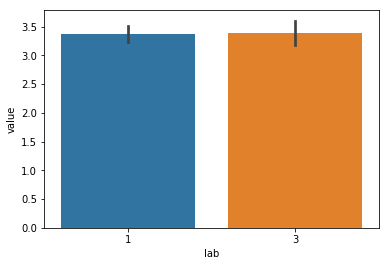

In [76]:
plt.close()
sns.barplot('lab','value',data=forplot)
plt.show()

In [78]:
results = pandas.DataFrame(index = all_3.index, columns = ['t','p'])
for i in all_3.index:
    results.loc[i, ['t','p']] = stats.ttest_ind(all_1.loc[i], all_3.loc[i])

In [82]:
results.sort_values('p').head()

,t,p
44179,-6.09691,7.26178e-09
43548,-5.73274,4.52019e-08
8485,-5.71059,5.04075e-08
32789,-5.60304,8.52542e-08
12996,-5.57784,9.63361e-08


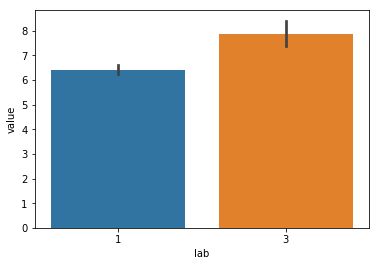

In [83]:
forplot = pandas.DataFrame(pandas.concat([all_1.loc[44179], all_3.loc[44179]]))
forplot.columns = ['value']
forplot.loc[:, 'lab'] = [1]*len(all_1.columns) + [3]*len(all_3.columns)
forplot.head()
plt.close()
sns.barplot('lab','value',data=forplot)
plt.show()

In [88]:
results.loc[:,'Q_hs'] = multipletests(results.p)[1]
results.loc[:,'Q_bh'] = multipletests(results.p, method = 'fdr_bh')[1]
results.loc[:,'Q_bonf'] = multipletests(results.p, method = 'bonferroni')[1]

In [95]:
results[results.Q_bonf<0.05]

,t,p,Q_hs,Q_bh,Q_bonf
117,-5.13581,7.75626e-07,0.0444639,0.000826115,0.0455231
246,-5.12092,8.30451e-07,0.0475262,0.000826115,0.0487408
734,-5.31722,3.33999e-07,0.019405,0.000760967,0.0196031
735,-5.16901,6.65736e-07,0.0382917,0.000826115,0.0390734
4273,-5.48998,1.47116e-07,0.00859634,0.000760967,0.00863453
4428,-5.15184,7.20516e-07,0.041373,0.000826115,0.0422885
5171,-5.15502,7.10062e-07,0.0407865,0.000826115,0.0416749
5647,-5.46691,1.64299e-07,0.00959506,0.000760967,0.00964303
7432,-5.3339,3.08813e-07,0.0179555,0.000760967,0.0181248
7506,-5.2688,4.19005e-07,0.0242809,0.000760967,0.0245922


In [96]:
probes = pandas.read_csv('/data1/users/jvogel/Allen_Human_Brain_Atlas/normalized_microarray_donor10021/Probes.csv')

In [99]:
probes.loc[results[results.Q_bonf<0.05].index]['gene_symbol'].tolist()

['CD22',
 'TBCB',
 'AKR1C1',
 'AKR1C1',
 'PCBD1',
 'PET112L',
 'RABGGTB',
 'SCD',
 'ZNF193',
 'SCG2',
 'AKR1C3',
 'GRHPR',
 'DDX39',
 'RIMS3',
 'SDS',
 'SNAPIN',
 'IFIT5',
 'LACTB2',
 'GOLGA7',
 'CCDC93',
 'SLC38A2',
 'CRTAC1',
 'SENP2',
 'POGK',
 'PAAF1',
 'ADIPOR2',
 'YTHDC1',
 'DNER',
 'COMMD7',
 'NUDT10',
 'ZNF775',
 'PRMT2',
 'FNTA',
 'SLC44A1',
 'UHRF2',
 'ENPP4',
 'BRD8',
 'DIP2B',
 'TBC1D2',
 'SLAIN1',
 'AC106818.2',
 'TBC1D12',
 'C14orf109',
 'DBNDD2',
 'GKAP1',
 'TSEN15',
 'C7orf16',
 'NR2F2',
 'DBNDD2',
 'MID1IP1',
 'TLE2',
 'LOC151162',
 'RBPJP6',
 'FAM149B1',
 'PLAC2',
 'KIAA1310',
 'SYNGR2',
 'SLC20A1',
 'A_23_P377350']

In [104]:
probes.loc[results[results.Q_bonf<0.05].index]['entrez_id'][:-1].astype('int').tolist()

[933,
 1155,
 1645,
 1645,
 5092,
 5188,
 5876,
 6319,
 7746,
 7857,
 8644,
 9380,
 10212,
 9783,
 10993,
 23557,
 24138,
 51110,
 51125,
 54520,
 54407,
 55118,
 59343,
 57645,
 80227,
 79602,
 91746,
 92737,
 149951,
 170685,
 285971,
 3275,
 2339,
 23446,
 115426,
 22875,
 10902,
 57609,
 55357,
 122060,
 441094,
 23232,
 26175,
 55861,
 80318,
 116461,
 10842,
 7026,
 55861,
 58526,
 7089,
 151162,
 643198,
 317662,
 257000,
 55683,
 9144,
 6574]

In [106]:
all_1.to_csv('/data1/users/jvogel/Allen_Human_Brain_Atlas/all_in_HV_Label_1.csv')
all_3.to_csv('/data1/users/jvogel/Allen_Human_Brain_Atlas/all_in_HV_Label_3.csv')
results.to_csv('/data1/users/jvogel/Allen_Human_Brain_Atlas/results_lab_1_vs_2.csv')

TO DO:
- Try results again after correcting for donor and (plate?).
- Do gene annotation once more, this time using FDR corrected IDs (many more)
- Look at associations with hit genes and tau

In [105]:
# DAVID gene annotation: https://david.ncifcrf.gov/summary.jsp
# String-DB https://string-db.org/
# RICHIARDI PAPER https://www.ncbi.nlm.nih.gov/pubmed/26068849


In [110]:
len(probes.loc[results[results.Q_bh<0.05].index]['entrez_id'].dropna().astype('int').tolist())

7502

In [111]:
probes.columns

Index(['probe_id', 'probe_name', 'gene_id', 'gene_symbol', 'gene_name',
       'entrez_id', 'chromosome'],
      dtype='object')

In [116]:
len(np.unique(probes.entrez_id.dropna().astype(int)))

20787

In [117]:
jnkdf = pandas.DataFrame(np.unique(probes.entrez_id.dropna().astype(int)))

In [121]:
jnkdf.to_csv('/data1/users/jvogel/Allen_Human_Brain_Atlas/background.csv',sep='\t')

In [120]:
jnkdf.to_csv?

In [131]:
scans = sorted(glob('/home/users/jvogel/Science/datasets/ADNI_AV1451_template_space/*/TAU*.nii'))

In [137]:
scans[0].split('/')[7]

'002_S_4229'

In [141]:
tids = [x.split('/')[7] for x in scans]

In [142]:
tauz = pandas.DataFrame(index = coords.index,columns = tids)

In [146]:
for i,row in coords.iterrows():
    x,y,z = convert_coords([row['mni_x'],row['mni_y'],row['mni_z']],to_what='xyz')
    coords.loc[i,'x'] = x
    coords.loc[i,'y'] = y
    coords.loc[i,'z'] = z

In [148]:
i4d = image.load_img(scans)

In [150]:
i4d.shape

(121, 145, 121, 91)

In [165]:
i4d = i4d.get_data()

In [177]:
for i,row in coords.iterrows():
    x,y,z = int(round(row['x'])),int(round(row['y'])),int(round(row['z']))
    tauz.loc[i,:] = i4d[x,y,z,:]

IndexError: index 155 is out of bounds for axis 1 with size 145

In [162]:
x,y,z

(119, 132, 69)

In [164]:
i4d[119,132,69,:]

TypeError: __getitem__() takes 1 positional argument but 2 were given